# Red neuronal artificial en Numpy - MNIST

Bibliografía:
- Deep Learning with Python (capítulo 2), Francois Chollet, 2018 Manning
- https://www.coursera.org/learn/neural-networks-deep-learning/lecture/6dDj7/backpropagation-intuition-optional, Andrew Ng, 2018 DeepLearning.ai
- Learning Tensor Flow, Tom Hope, Yehezkel S. Resheff & Itay Lieder, 2017 O'Reilly
- TensorFlow for Deep Learning, Bharath Ramsundar & Reza Bosagh Zadeh, 2018, O'Reilly
- Python Machine Learning, 2nd ed. (capítulo 13), Sebastian Rachska, 2017 Packt
- Machine Learning with TensrFlow (capítulo 7), Nishant Shukla, 2018 Manning


Vamos en este notebook a implementar una red neuronal que permita la clasificación de imágenes de dígitos en escala de grises, utilizando tres niveles de extracción de programación.

Además de utilizar **numpy**, aprovechamos para presentar las librerías **tensorflow** y **keras** a través de su aplicación al problema de clasificación mencionado. 
El modelo a implementar es una red con una capa escondida de 512 neuronas utilizando la función de activación **ReLU** y 10 neuronas de salida utilizando la función de activación **softmax**.

Vamos a seguir un protocolo de *holdout* para evaluar los clasificadores.

# Exploración y entendimiento del dataset MNIST

## Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import tensorflow as tf
tf.__version__

'1.8.0'

Keras necesita una base para trabajar. Vamos a usar tensorflow

In [3]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

Keras viene con MNIST directamente integrada. Las imagenes y sus etiquetas (clases) ya vienen particionadas en training y test sets.

## Carga de datos

In [4]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
train_images[0][5] #La primera imagen, la 6a fila, muestra los 28 valores de gris (uno por cada columna)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
        18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
         0,   0], dtype=uint8)

In [6]:
train_images.shape

(60000, 28, 28)

La primera dimension del tensor de train_images es de 60000, pues hay 60000 imagenes, las 2 siguientes dimensiones son las que dan el tamaño de las imágenes (28x28). Como son imagenes en escala de grises, no hay una 4a dimensión que tendría el canal de color (e.g. RGB). Cada valor de la matriz de 28x28 es una valor de gris de 0 a 255.

In [7]:
len (train_labels)

60000

In [8]:
len (test_labels)

10000

El testset tiene 10000 imágenes

In [9]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [10]:
test_images.shape

(10000, 28, 28)

Podemos ver cada una de las imágenes

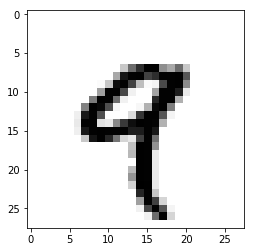

In [11]:
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

## Preprocesamiento de los datos

Necesitamos que los datos de entrenamiento y test estén en el formato dado por la capa de entrada de la red, donde se reciben los datos representados a partir de un tensor cuya primera dimensión tiene 784 neuronas, es decir, recibe como input instancias representadas por tensores con dimensionalidad (784,).

Cómo los datos de entrenamiento están en tensores de 60000x28x28, es necesario convertirlos en un tensor de 60000x784. Idem para el tensor de test.

Vamos también a modificar la escala de grises, que originalmente va de 0 a 255, a una escala que vaya de 0 a 1. Para esto, dividimos los valores originales por 255.

Definimos la estructura de la red (número de neuronas por capa y número de inputs).

In [12]:
n0 = 28*28
n1 = 512
n2 = 10

Vamos a aplanar los datos de train y test para poder utilizar cada pixel como un predictor (cada pixel en una columna diferente).

In [13]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

Las etiquetas están en valores numéricos, vamos codificarlos en one hot encoding, con un vector de K posiciones para K clases, donde la clase específica de cada ejemplo tiene un valor de 1, y las demas posiciones del vector tienen valores de 0

In [14]:
train_labels[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [15]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [16]:
train_labels.shape

(60000, 10)

In [17]:
test_labels.shape

(10000, 10)

In [18]:
train_labels[0:2]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Como los labels están desordenados y no responde a ninguna organización sistemática, los podemos dejar así. Si siguieran un orden definido, sería necesario barajarlos para que el orden no influyera en el aprendizaje.

In [19]:
X_train = train_images.T
y_train = train_labels.T
m=X_train.shape[1]

# MNIST: ANN con Numpy 

Definimos las funciones de activación y sus gradientes.

La función de activación de softmax solo se puede utilizar en la última capa y generaliza la función sigmoide, por lo que su gradiente es el mismo que el del caso binario.

In [20]:
def sigmoide(x):
    return 1/(1+np.exp(-x))

def sigmoideGrad(x):
    return x*(1-x)

def softmax(X):
    ...TODO...
    return ...


In [135]:
def tanh(x):
    ...TODO...
    return ...

def tanhGrad(x):
    ...TODO...
    return ...

In [136]:
def relu(x):
    ...TODO...
    return ...

def reluGrad(x):
    ...TODO...
    return ...


## Inicialización de los parámetros

Inicializamos los pesos de la red aleatoriamente para la capa intermedia (1) y la capa de salida (2). La capa inicial no tiene pesos pues consiste únicamente de los datos de entrada.

La primera capa tiene n1 (512) neuronas y n0 (784) inputs, creamos una matriz de pesos w1 con n1 filas y n0 columnas. Tenemos además un vector b1 con n1 posiciones.

La segunda capa tiene n2 (10) neuronas y n1 (512) inputs, creamos una matriz de pesos w2 con n2 fila y n1 columnas. Tenemos además un vector b2 con n2 posiciones.

In [86]:
def initParams():
    np.random.seed(123456)

    ...TODO...

    return(w1, b1, w2, b2)

In [87]:
w1, b1, w2, b2 = initParams()
print("inputs: ", train_images.shape)
print("w1: {%s}\nb1: {%s}" % (w1.shape, b1.shape))
print("w2: {%s}\nb2: {%s}" % (w2.shape, b2.shape))

inputs:  (60000, 784)
w1: {(512, 784)}
b1: {(512, 1)}
w2: {(10, 512)}
b2: {(10, 1)}


## Feed Forward

Comenzamos por definir la función feedForward, que recibe la matriz de inputs con todos los registros y retorna el vector con las predicciones correspondientes:

In [88]:
def feedForward(X, w1, b1, w2, b2):
    '''Calcula el valor predicho para todos los registros que se encuentran en X
       -----------
       Argumentos:
       X: matriz con los inputs, con tantas filas como atributos y tantas columnas como registros
       w1: matriz con los pesos de las conexiones entrantes de la 1a capa, 
         con tantas filas como atributos y tantas columnas como registros
       b1: array con los sesgos de las neuronas de la 1a capa
       w2: matriz con los pesos de las conexiones entrantes de la 2a capa, 
         con tantas filas como atributos y tantas columnas como registros
       b2: array con los sesgos de las neuronas de la 2a capa
       -----------
       Retorna:
       a1: matriz con las activaciones de la capa escondida, 
         con tantas filas como neuronas de la capa y tantas columnas como registros
       a2 (y estimado): vector con las predicciones
    '''

    ...TODO...

    return (a1, a2)

Podemos entonces evaluar el estado inicial de la red (con sus parámetros iniciales):

In [89]:
a1, a2 = feedForward(X_train, w1, b1, w2, b1)
print(a2.transpose())

[[0.10071491 0.10042403 0.10197454 ... 0.09950268 0.09953592 0.10050975]
 [0.09982152 0.09917264 0.10177136 ... 0.09984397 0.0986228  0.10154716]
 [0.10044414 0.09944697 0.10062615 ... 0.10005185 0.09904903 0.09962872]
 ...
 [0.10024492 0.1008202  0.10049123 ... 0.09974311 0.10031068 0.09981346]
 [0.10037734 0.09966835 0.10097462 ... 0.09993777 0.09929817 0.10047747]
 [0.09963554 0.10080644 0.10104211 ... 0.09960428 0.09928018 0.10077153]]


Vemos que casi todas las probabilidades son cercanas al 10%, por lo que no hay inicialmente ninguna predilección definida por ninguno de los dígitos del 0 al 9.

## Función de costo

La función de perdida es la **categorical_crossentropy**, que se utiliza en el caso de problemas de clasificación multiclase. El optimizador tratará de minimizarla. Es una función de distancia entre el valor real (que solo tiene una de las dimensiones con un 1 y las demás con un 0) y el predicho por el modelo (que tiene una distribución que probablemente no sea absoluta, sino que reparta la unidad de probabilidad en cada una de las clases).
Esta función es la suma negativa de las entropias de cada una de las posiciones del vector one hot encoded de clases:
$$H(y,\tilde{y}) =-\sum{y*log(\tilde{y})}$$
Como el valor de *y* es solo 1 en una de las posiciondes del vector de clases y 0 en las demás, solo una posición será considerada, de tal manera que la similitud entre los valores reales (1) y predichos (fracción de 1) es dada por el log del valor predicho para la clase real.  

In [90]:
def costoGlobal(y_real, y_est): 
    '''Calcula el costo global de la predicción con la red actual, comparando la clase real con las probabilidad estimadas
       -----------
       Argumentos:
       y_real: Matriz con las clases reales de los datos. numcols = registros, numrows = 10
       y_est: array con las probabilidades de salida estimadas por la red
       -----------
       Retorna:
       costo: promedio de los costos de cada predicción individual
    '''
    
    ...TODO...

    return ...

In [91]:
costo = costoGlobal(y_train, a2)
costo

3.8408622903772436e-05

## Función de backpropagation

In [92]:
def backProp(X, y, w1, b1, w2, b2, a1, a2): 
    '''Calcula los deltas de las actualizaciones de los parámetros de las capas 
       -----------
       Argumentos:
       X: matriz con los inputs, con tantas filas como atributos y tantas columnas como registros
       y: array con los valores reales a predecir
       w1: matriz con los pesos de las conexiones entrantes de la 1a capa, 
         con tantas filas como atributos y tantas columnas como registros
       w2: matriz con los pesos de las conexiones entrantes de la 2a capa, 
         con tantas filas como atributos y tantas columnas como registros
       b1: array con los sesgos de las neuronas de la 1a capa
       b2: array con los sesgos de las neuronas de la 2a capa
       a1: matriz con las activaciones de la capa escondida, con tantas filas como neuronas de la capa y tantas columnas como registros
       a2 (y estimado): matriz con las predicciones, con tantas columnas como registros y 10 filas (1 por cada dígito)
       -----------
       Retorna:
       dw1: matriz con las actualizaciones que se deben aplicar a los coeficientes de la capa 1 (hidden)
       db1: array con las actualizaciones que se deben aplicar a los sesgos de la capa 1 (hidden)
       dw2: matriz con las actualizaciones que se deben aplicar a los coeficientes de la capa 2 (salida)
       db2: array con las actualizaciones que se deben aplicar a los sesgos de la capa 2 (salida)
    '''

    ...TODO...

    return (dw1, db1, dw2, db2)

In [93]:
dw1, db1, dw2, db2 = backProp(X_train, y_train, w1, b1, w2, b2, a1, a2)

## Ciclo de entrenamiento

Vamos ahora a programar el ciclo (época) de back propagation.
- Se calculan los valores intermediarios en la fase forward: a0 (son las entradas X), a1 y a2 (las salidas estimadas y_est)
- Se calcula el error de cada época
- Se encuentran los valores de los gradientes en la fase backward a partir de los resultados anteriores

Definimos los hiperparámetros del modelo, utilizados para aprender los pesos de las capas (los verdaderos parámetros).

In [94]:
lr = 0.5 # learning rate
epocas = 100 # Iteraciones de backpropagation

In [95]:
def entrenarRed(epocas, lr, X, y, w1, b1, w2, b2, a1, a2, echo_progression=True):
    for i in range(epocas):

        ...TODO...
        
    return (costo, w1, b1, w2, b2)

In [96]:
costo, w1, b1, w2, b2 = entrenarRed(epocas, lr, X_train, y_train, w1, b1, w2, b2, a1, a2)

Epoca %d, costo = %10.8f 0 3.8408622903772436e-05
Epoca %d, costo = %10.8f 10 2.7411510408127332e-05
Epoca %d, costo = %10.8f 20 1.324481886758361e-05
Epoca %d, costo = %10.8f 30 9.572798210976057e-06
Epoca %d, costo = %10.8f 40 8.046299617226456e-06
Epoca %d, costo = %10.8f 50 7.217797516259726e-06
Epoca %d, costo = %10.8f 60 6.705699346742406e-06
Epoca %d, costo = %10.8f 70 6.357649585970123e-06
Epoca %d, costo = %10.8f 80 6.103382347304558e-06
Epoca %d, costo = %10.8f 90 5.907515773805755e-06


Nuestras predicciones finales son: 

In [137]:
_, a2 = feedForward(X_train, w1, b1, w2, b1)

y_pred = np.argmax(a2, axis=0)
y_real = np.argmax(y_train, axis=0)
print(confusion_matrix(y_pred, y_real))
print(classification_report(y_pred, y_real))

[[5690    0   58   23   15  101   48   39   33   46]
 [   0 6519   78   33   34   44   21   64  142   33]
 [  33   32 5182  141   35   35   67   89   81   29]
 [  16   32  104 5361    4  245    3   24  176   79]
 [  13    6  110    4 5350   69   68   66   31  211]
 [  52   31   16  260    6 4465   83   10  189   42]
 [  40    9  132   32   75  127 5585    2   53    5]
 [  10   19   86   79   10   28    0 5732   20  226]
 [  63   86  165  125   35  233   42   19 5028   60]
 [   6    8   27   73  278   74    1  220   98 5218]]
             precision    recall  f1-score   support

          0       0.96      0.94      0.95      6053
          1       0.97      0.94      0.95      6968
          2       0.87      0.91      0.89      5724
          3       0.87      0.89      0.88      6044
          4       0.92      0.90      0.91      5928
          5       0.82      0.87      0.84      5154
          6       0.94      0.92      0.93      6060
          7       0.91      0.92      0.92  

Veamos como nos va con el set de test

In [138]:
X_test = test_images.T
y_test = test_labels.T

In [141]:
_, a2 = feedForward(X_test, w1, b1, w2, b1)

y_pred = np.argmax(a2, axis=0)
y_real = np.argmax(y_test, axis=0)
print(confusion_matrix(y_pred, y_real))
print(classification_report(y_pred, y_real))

[[ 957    0   12    5    1   17   17    6    8   11]
 [   0 1107    9    0    1    3    3   14    8    8]
 [   4    1  902   21    6    4    7   25    9    5]
 [   2    4   17  898    1   49    0    5   28   11]
 [   0    1   14    0  907   11   13    8   10   41]
 [   7    1    1   38    0  740   16    0   31   13]
 [   7    4   15    1   12   15  896    0   13    0]
 [   1    1   13   18    2    9    1  930   11   30]
 [   2   16   43   21    8   37    5    4  841    4]
 [   0    0    6    8   44    7    0   36   15  886]]
             precision    recall  f1-score   support

          0       0.98      0.93      0.95      1034
          1       0.98      0.96      0.97      1153
          2       0.87      0.92      0.89       984
          3       0.89      0.88      0.89      1015
          4       0.92      0.90      0.91      1005
          5       0.83      0.87      0.85       847
          6       0.94      0.93      0.93       963
          7       0.90      0.92      0.91  